In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [221]:
height, width = 92, 92

### Load image data

In [229]:
# get filenames
dirpath = "data/train/"
fns = os.listdir(dirpath)

In [242]:
cats = []
dogs = []
for i in fns:
    if "cat" in i:
        cats.append(i)
    else:
        dogs.append(i)

In [243]:
# throw away 75% of the dog filenames to induce class imbalance
dogs = dogs[:len(dogs)//4]

In [244]:
dogs = [dirpath+s for s in dogs]

In [245]:
cats = [dirpath+s for s in cats]

### Read image data

In [247]:
from skimage import io, transform, color
def read_image(fn, imsize):
    im = io.imread(fn)
    im = color.rgb2gray(im)
    im = transform.resize(im, imsize, mode='constant')
    im = im[..., np.newaxis] # add empty channels axis
    return im

In [248]:
# read in cat images (using parallelization to speed up loading)
from joblib import Parallel, delayed
img_cats = np.array( Parallel(n_jobs=-1)(delayed(read_image)(i, (height, width)) for i in cats))
img_cats.shape

# read in dog images (using parallelization to speed up loading)
img_dogs = np.array( Parallel(n_jobs=-1)(delayed(read_image)(i, (height, width)) for i in dogs))
img_dogs.shape

(1562, 92, 92, 1)

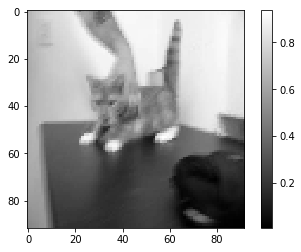

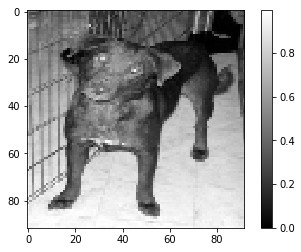

In [249]:
plt.imshow(np.squeeze(img_cats[0]), cmap='gray')
plt.colorbar()
plt.show()

plt.imshow(np.squeeze(img_dogs[0]), cmap='gray')
plt.colorbar()
plt.show()

In [250]:
# combine the two image classes
x = np.concatenate([img_cats, img_dogs], axis=0)
# construct labels from the number of files in each class
y = np.array([0]*len(img_cats) + [1]*len(img_dogs))

print(x.shape)
print(y.shape)

(14062, 92, 92, 1)
(14062,)


### Split into training and test set

In [251]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

### Compute class weights to address class imbalance

In [252]:
np.unique(y, return_counts=True)

(array([0, 1]), array([12500,  1562]))

In [253]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(np.squeeze(y)), np.squeeze(y))
class_weights

array([0.56248   , 4.50128041])

### Convolutional Network Model
* Take Inception V3, without pretrained weights, without dense top
* Inception V3 probably an overkill for the data, but we can tune the model down later

In [254]:
 def construct_model():
    from keras.applications import InceptionV3
    from keras.models import Model
    from keras.layers import Dense
    model = InceptionV3(input_shape=(None, None, 1), 
                        weights=None, 
                        include_top=False, 
                        pooling='max')
    
    
    x = Dense(256, activation='relu')(model.output)
    x = Dense(128, activation='relu')(model.output)
    o = Dense(1, activation='sigmoid')(x)
    return Model(inputs=model.input, outputs=o)

model = construct_model()

In [255]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

### Loss function
To counter large class imbalance in samples

In [256]:
def focal_loss(gamma=2., alpha=.25):
    '''
    Loss function for binary classification with large class imbalance.
    Based on binary crossentropy, but it focuses on hard examples instead and less on easy samples.   
    
    Paper: https://arxiv.org/pdf/1708.02002.pdf
    Keras implementation: https://github.com/mkocabas/focal-loss-keras/blob/master/focal_loss.py
    '''
    import tensorflow as tf
    import keras.backend as K 
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

### Data augmentation

In [257]:
def generate_batch(batch_size, rotation=True):
    while True:
        # take random sample from x_train
        samples_ind = np.random.randint(low=0, high=len(x_train), size=batch_size)
        x_batch = x_train[samples_ind]
        y_batch = y_train[samples_ind]
        for i in range(batch_size):
            if rotation:
                rotations = np.random.randint(0,3)
                x_batch[i] = np.rot90(x_batch[i], k=rotations)
        yield x_batch, y_batch

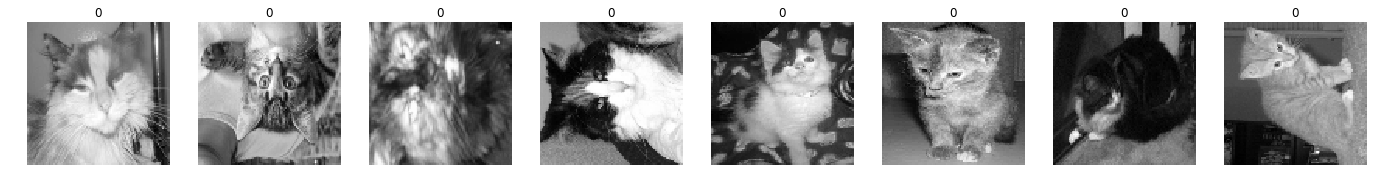

In [261]:
# test data augmentation
n=8
x_batch, y_batch = next(generate_batch(n))
fig, ax = plt.subplots(1, n, figsize=(n*3, 3))
for i,a in enumerate(ax.flatten()):
    a.imshow(np.squeeze(x_batch[i]), cmap='gray')
    a.set_title(y_batch[i])
    a.axis('off')

### Compile
with focal loss where alpha is set to the inverse class frequency computed above

In [262]:
gamma = 2.0
alpha = class_weights[0] 
model.compile(optimizer='adam', 
              loss=focal_loss(gamma=gamma, alpha=alpha), 
              metrics=['accuracy'])

### Train

In [263]:
batch_size = 4
epochs = 10

train_generator = generate_batch(batch_size=batch_size)
test_generator  = generate_batch(batch_size=batch_size, rotation=False)

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=len(x_train) // batch_size,
                              epochs=epochs, 
                              validation_data=test_generator,
                              validation_steps=len(x_test) // batch_size)

Epoch 1/10
2636/2636 [==============================] - 444s 169ms/step - loss: 0.2086 - acc: 0.8867 - val_loss: 0.2046 - val_acc: 0.8874
Epoch 2/10
2636/2636 [==============================] - 437s 166ms/step - loss: 0.1892 - acc: 0.8952 - val_loss: 0.1924 - val_acc: 0.8908
Epoch 3/10
2636/2636 [==============================] - 440s 167ms/step - loss: 0.1936 - acc: 0.8913 - val_loss: 0.1972 - val_acc: 0.8948
Epoch 4/10
2636/2636 [==============================] - 454s 172ms/step - loss: 0.1956 - acc: 0.8892 - val_loss: 0.1871 - val_acc: 0.8985
Epoch 5/10
2636/2636 [==============================] - 460s 174ms/step - loss: 0.1931 - acc: 0.8889 - val_loss: 0.1928 - val_acc: 0.8882
Epoch 6/10
2636/2636 [==============================] - 462s 175ms/step - loss: 0.1867 - acc: 0.8943 - val_loss: 0.1952 - val_acc: 0.8859
Epoch 7/10
2636/2636 [==============================] - 456s 173ms/step - loss: 0.1924 - acc: 0.8887 - val_loss: 0.1898 - val_acc: 0.8914
Epoch 8/10
2636/2636 [============

### Predict

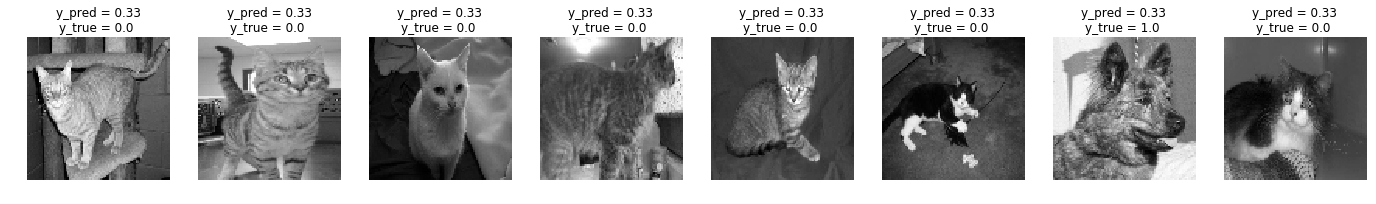

In [264]:
n = 8
y_pred = model.predict(x_test[:8])

fig, ax = plt.subplots(1,n, figsize=(n*3, 3))
for i, a in enumerate(ax.flatten()):
    a.imshow(np.squeeze(x_test[i]), cmap='gray')
    a.set_title('y_pred = {:.2f}\ny_true = {:.1f} '.format(y_pred[i][0], y_test[i]))
    a.axis('off')